In [1]:
import torch
import pandas as pd
from matplotlib import pyplot as plt
from basis import *
import nf_library

device = torch.device('cpu')

In [2]:
mu_a,sig_a = 10,1
shape_gt,scale_gt = 9,1

In [3]:
x = torch.tensor(pd.read_csv('datasets/N_{}_{}_G_{}_{}.csv'.format(mu_a,sig_a,shape_gt,scale_gt),header=None).to_numpy()[:10000].reshape(-1))
bins = torch.linspace(x.min(),x.max(),21).numpy()
xb = torch.linspace(1e-3,(x.max().item()-mu_a/2),10000).reshape(-1).to(device)
p_gt = torch.exp(logprob_gamma(xb,torch.tensor(shape_gt),torch.tensor(scale_gt)))


In [4]:
def Bayes_fig(ax,N):
    filename = 'models/sum_bayes_N_{}_{}_G_{}_{}datapoints_{}.csv'.format(mu_a,sig_a,shape_gt,scale_gt,N)
    shape,scale,lps =  torch.tensor(pd.read_csv(filename).to_numpy()[:,1:].T)

    i = torch.argmax(lps)
    p_map = torch.exp(logprob_gamma(xb,shape[i],scale[i]))


    logp = torch.logsumexp(torch.vstack([logprob_gamma(xb,sh,sc) for (sh,sc) in zip(shape,scale)]),axis=0)-torch.log(torch.tensor(len(lps))).to(device)
    p = torch.exp(logp)
    
    ax.plot(xb.cpu(),p_gt.cpu(),label='Ground Truth ', lw = 2.0,color='k')
    ax.plot(xb.cpu(),p_map.cpu(),label='MAP'.format(KL(p_gt,p_map,xb)))
    ax.plot(xb.cpu(),p.cpu(),label='Reconstruction'.format(KL(p_gt,p,xb)))
    ax.legend()


def Mixture_fig(ax,N,Ncomp=20,burn=5000):

    def logprob_mixgaussian(x,mus,sigs,rhos):
        ind = rhos>rhos.max()/100
        print(ind.sum())
        m,s,r = mus[ind],sigs[ind],rhos[ind]
        r = normalize(r)
        return torch.logsumexp(logprob_gaussian(x,m.reshape(-1,1),s.reshape(-1,1))+torch.log(r.reshape(-1,1)),axis=0)
    logprob_mixgaussian = lambda x,mus,sigs,rhos:torch.logsumexp(logprob_gaussian(x,mus.reshape(-1,1),sigs.reshape(-1,1))+torch.log(rhos.reshape(-1,1)),axis=0)

    filename = 'models/sum_npbayes_N_{}_{}_G_{}_{}datapoints_{}.csv'.format(mu_a,sig_a,shape_gt,scale_gt,N)
    g = pd.read_csv(filename).to_numpy()[:,1:]
    thetas,lps = torch.tensor(g[burn:,:-1]),torch.tensor(g[burn:,-1])
    print(g.shape)

    i = torch.argmax(lps)
    
    th_map = thetas[i]
    p_map = torch.exp(logprob_mixgaussian(xb,th_map[:Ncomp],th_map[Ncomp:2*Ncomp],th_map[2*Ncomp:]))

    logp = torch.logsumexp(torch.vstack([logprob_mixgaussian(xb,th[:Ncomp],th[Ncomp:2*Ncomp],th[2*Ncomp:]) for th in thetas]),axis=0)-torch.log(torch.tensor(len(lps))).to(device)
    p = torch.exp(logp)
    
    ax.plot(xb.cpu(),p_gt.cpu(),label='Ground Truth ', lw = 2.0,color='k')
    ax.plot(xb.cpu(),p_map.cpu(),label='MAP')
    ax.plot(xb.cpu(),p.cpu(),label='Reconstruction')
    ax.legend()


def NF_fig(ax,N):
    model = nf_library.NormalizingFlow_shifted(device)
    model.load_state_dict(torch.load('models/sum_nf_N_{}_{}_G_{}_{}datapoints_{}.pt'.format(mu_a,sig_a,shape_gt,scale_gt,N).format(N)))
    p_nf = torch.exp(model.log_prob(xb.reshape(-1,1))).detach()
    ax.plot(xb.cpu(),p_gt.cpu(),label='Ground Truth ', lw = 2.0,color='k')
    ax.plot(xb.cpu(),p_nf.cpu(),label='NF',color='r')
    ax.legend()
    return model


(15000, 61)
(15000, 61)
(15000, 61)


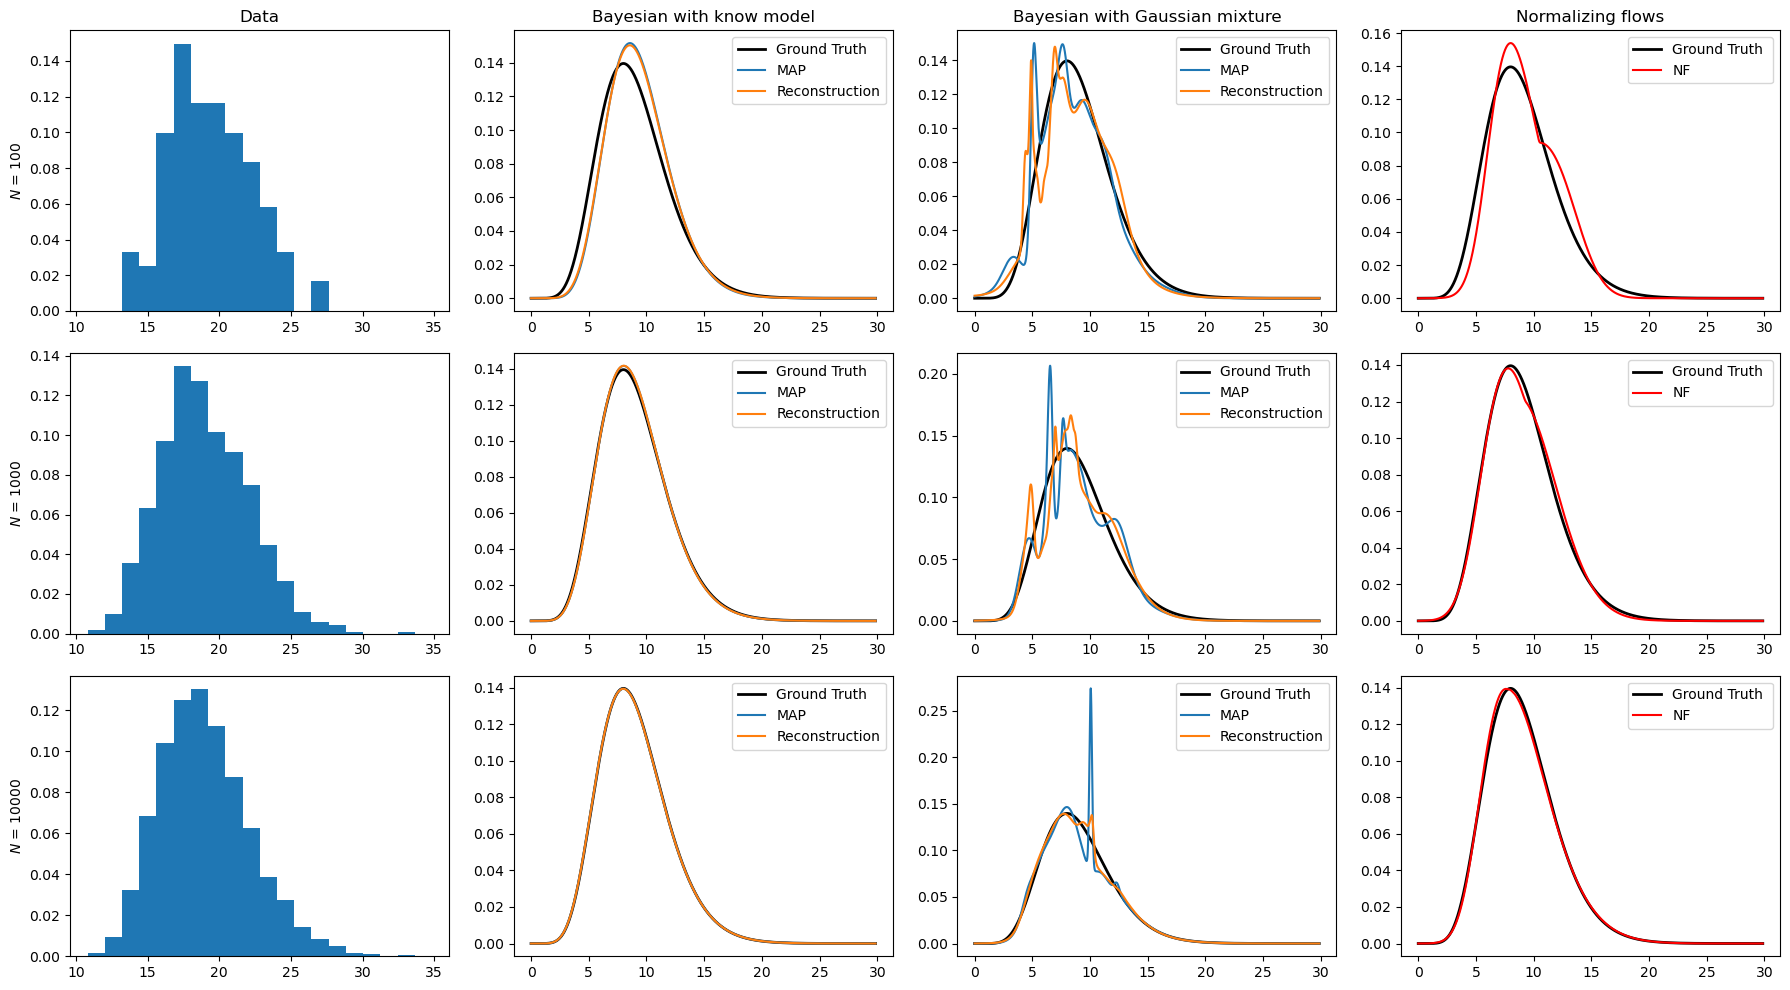

In [7]:
fig,axs = plt.subplots(3,4,figsize=(18,10))
for (ax,N) in zip(axs,(100,1000,10000)):
    ax[0].hist(x[:N],density=True,bins=bins)
    Bayes_fig(ax[1],N)
    Mixture_fig(ax[2],N)
    model = NF_fig(ax[3],N)

    ax[0].set_ylabel(r'$N$ = {}'.format(N))

[ax.set_title(tit,fontsize=12) for (tit,ax) in zip(('Data', 'Bayesian with know model', 'Bayesian with Gaussian mixture', 'Normalizing flows'), axs[0])]
plt.tight_layout()
plt.savefig('graphs/fig2.png',dpi=500)

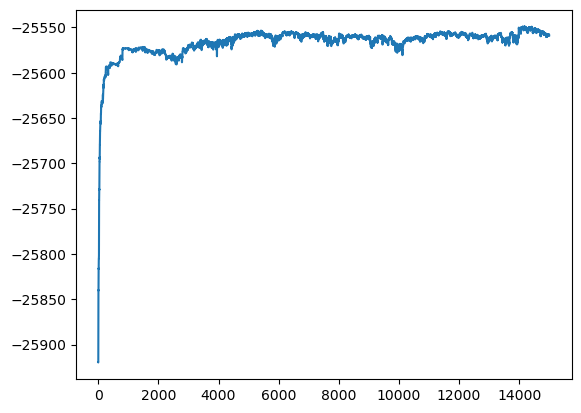

In [ ]:
filename = 'models/sum_npbayes_N_{}_{}_G_{}_{}datapoints_{}.csv'.format(mu_a,sig_a,shape_gt,scale_gt,10000)
g = pd.read_csv(filename).to_numpy()[:,-1]
plt.plot(g)

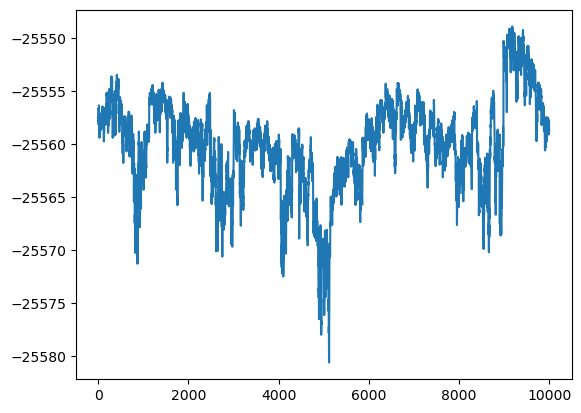

In [ ]:
plt.plot(g[5000:])

In [ ]:
a = ''
for i in range(3,10):
    for j in (100,316,1000,3160,10000):
        a+= 'python SUM_NPBayes.py {} {};'.format(j,i)
a

'python SUM_NPBayes.py 100 3;python SUM_NPBayes.py 316 3;python SUM_NPBayes.py 1000 3;python SUM_NPBayes.py 3160 3;python SUM_NPBayes.py 10000 3;python SUM_NPBayes.py 100 4;python SUM_NPBayes.py 316 4;python SUM_NPBayes.py 1000 4;python SUM_NPBayes.py 3160 4;python SUM_NPBayes.py 10000 4;python SUM_NPBayes.py 100 5;python SUM_NPBayes.py 316 5;python SUM_NPBayes.py 1000 5;python SUM_NPBayes.py 3160 5;python SUM_NPBayes.py 10000 5;python SUM_NPBayes.py 100 6;python SUM_NPBayes.py 316 6;python SUM_NPBayes.py 1000 6;python SUM_NPBayes.py 3160 6;python SUM_NPBayes.py 10000 6;python SUM_NPBayes.py 100 7;python SUM_NPBayes.py 316 7;python SUM_NPBayes.py 1000 7;python SUM_NPBayes.py 3160 7;python SUM_NPBayes.py 10000 7;python SUM_NPBayes.py 100 8;python SUM_NPBayes.py 316 8;python SUM_NPBayes.py 1000 8;python SUM_NPBayes.py 3160 8;python SUM_NPBayes.py 10000 8;python SUM_NPBayes.py 100 9;python SUM_NPBayes.py 316 9;python SUM_NPBayes.py 1000 9;python SUM_NPBayes.py 3160 9;python SUM_NPBayes.py

In [ ]:
x = model.nfm.q0.sample(30000)
x

tensor([[ 1.4306],
        [-0.6241],
        [-0.3982],
        ...,
        [ 0.9785],
        [ 0.5682],
        [-0.9775]])

In [ ]:
fs = model.nfm.flows
x1 = fs[0](x)
x2 = fs[1](x1[0])
fs[2](x2[0])

(tensor([[ 1.7749],
         [-0.2969],
         [-0.0809],
         ...,
         [ 1.3037],
         [ 0.8823],
         [-0.6264]], grad_fn=<IndexSelectBackward0>),
 tensor([-0.0009, -0.0009, -0.0009,  ..., -0.0009, -0.0009, -0.0009],
        grad_fn=<ViewBackward0>))

In [ ]:
y = (x,None)
for f in model.nfm.flows:
    y = f(y[0])

In [ ]:
y

(tensor([[ 1.4613],
         [-0.6514],
         [-0.4699],
         ...,
         [ 0.9136],
         [ 0.4556],
         [-0.9107]], grad_fn=<IndexSelectBackward0>),
 tensor([-0.0009, -0.0009, -0.0009,  ..., -0.0009, -0.0009, -0.0009],
        grad_fn=<ViewBackward0>))

(array([0.01066486, 0.15738472, 0.40673709, 0.37956178, 0.23458221,
        0.10115995, 0.03614449, 0.00972778, 0.00205265, 0.0005801 ]),
 array([-2.52088189, -1.77383029, -1.0267787 , -0.2797271 ,  0.4673245 ,
         1.21437609,  1.96142769,  2.7084794 ,  3.45553088,  4.20258236,
         4.94963408]),
 <BarContainer object of 10 artists>)

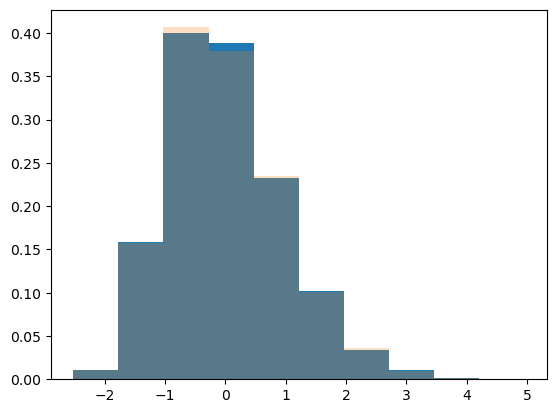

In [ ]:
h = plt.hist(y[0].detach().reshape(-1),density=True)
plt.hist(model.nfm.sample(30000)[0].detach().reshape(-1),alpha=.25,bins=h[1],density=True)

/home/pessoa/anaconda3/lib/python3.9/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


(array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]),
 array([-3.62988782, -3.3943007 , -3.15871358, -2.92312646, -2.68753934,
        -2.45195222, -2.2163651 , -1.98077798, -1.74519086, -1.50960374,
        -1.27401662]),
 <BarContainer object of 10 artists>)

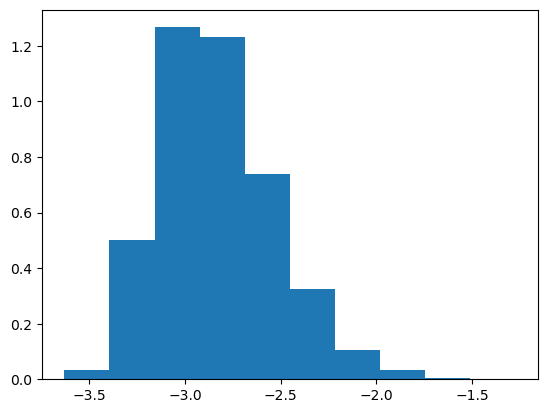

In [ ]:
h = plt.hist(model.zb(y[0]).detach().reshape(-1),density=True)
plt.hist(model.sample(30000)[0].detach().reshape(-1),alpha=.25,bins=h[1],density=True)

In [ ]:
model.zb(y[0])

tensor([[-2.3741],
        [-3.0403],
        [-2.9831],
        ...,
        [-2.5468],
        [-2.6912],
        [-3.1221]], grad_fn=<DivBackward0>)

In [ ]:
model.sample(30000)

(tensor([[ 9.9489],
         [15.9824],
         [ 7.9238],
         ...,
         [ 6.3472],
         [13.5228],
         [ 8.7330]], grad_fn=<AddBackward0>),
 tensor([-2.1983, -4.3773, -1.9740,  ..., -2.1198, -3.2872, -2.0206],
        grad_fn=<SubBackward0>))